In [704]:
os.chdir('/home/mike/Desktop/Word Embeddings')
import os
import pandas as pd
import pickle
from gensim.models import Word2Vec
from random import randint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

os.chdir('./Text Processing')
from TextPrep import TextPrep

os.chdir('../Meta Data')
from key_words import key_words, key_synonyms
from stop_words import stop_words
os.chdir('..')

In [705]:
def similar_words(word, model, topn):
    sim_words = []
    for i in range(topn):
        sim_words.append(model.wv.most_similar(word, topn = topn)[i][0])
    return sim_words + [word]

def similar_dict(words1, words2, labels):
    both = [word for word in words1 if word in words2]
    words1 = [word for word in words1 if word not in both]
    words2 = [word for word in words2 if word not in both]
    words = [words1, words2, both]
    labels = labels + ['Both']
    dictionary = {}
    for i in range(len(labels)):
        for word in words[i]:
            dictionary[word] = labels[i]
    return dictionary

def pca2df(pcamodel, embedding, dictionary):
    # convert the pca element to a df
    pc_df = pd.DataFrame(data = pcamodel, columns = ['pc1', 'pc2', 'pc3'])
    # add word column to the df
    pc_df['word'] = [key for key in embedding.wv.vocab]
    # get a list of unique words from the dictionary
    words = list(dictionary.keys())
    words = list(set(words))
    # keep only components that are in the list of unique words
    pc_df = pc_df[pc_df['word'].isin(words)].reset_index(drop=True)
    colors = {'Democrat': 'blue', 'Republican':'red', 'Both': 'purple', 'A': 'blue', 'B':'red'}
    pc_df['label'] = pc_df['word'].map(dictionary)
    pc_df['color'] = [colors[word] for word in pc_df['label']]
    return pc_df

In [706]:
# load in data
meta_data = pd.read_csv('Meta Data/meta_data.csv')
tweet_df = pd.read_csv('Data/aggregated_tweets.csv')
# subset to tweets after oct 29
tweet_df = tweet_df[tweet_df['created'] >= '2019-10-29']
# merge data with meta data
tweet_df = pd.merge(tweet_df, meta_data, how = 'inner', on = 'user_id')
tweet_df = tweet_df[tweet_df.party.isin(['R', 'D'])].reset_index(drop=True)

tweets = tweet_df['text']
labels = tweet_df['party']

# initialize parser
prep = TextPrep(stopwords = stop_words, key_words = key_words, key_synonyms = key_synonyms)

In [707]:
%%time
# preprocess text
tweets = [prep.twitter_preprocess(tweet) for tweet in tweets]

CPU times: user 456 ms, sys: 0 ns, total: 456 ms
Wall time: 455 ms


# Trump

### Trump Party Labels 

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


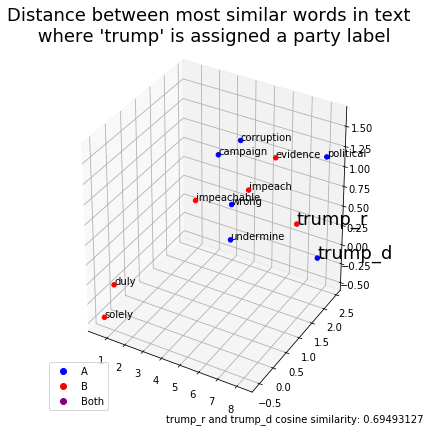

CPU times: user 1min 17s, sys: 3.16 s, total: 1min 20s
Wall time: 26.3 s


In [708]:
%%time
# tag keywords
ptrump_tweets = []
for i in range(len(tweets)):
    try:
        ptrump_tweets.append(prep.tag_keywords('trump', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
ptrump_tweets = prep.multi_lemmatizer(ptrump_tweets, threads = 6)

# drop single letters
for i in range(len(ptrump_tweets)):
    ptrump_tweets[i] = [word for word in ptrump_tweets[i] if len(word) > 1]

# train and save word2vec
ptrump_model = Word2Vec(ptrump_tweets, window = 10)
#ptrump_model.save('ptrump.model')
# assign data to variables
rtrump_words = similar_words('trump_r', ptrump_model, topn = 5)
dtrump_words = similar_words('trump_d', ptrump_model, topn = 5)
ptrump_sim = ptrump_similarity = ptrump_model.wv.similarity('trump_r', 'trump_d')
ptrump_dict = similar_dict(rtrump_words, dtrump_words, ['Republican', 'Democrat'])

# fit pca model
data = ptrump_model[ptrump_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, ptrump_model, ptrump_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['trump_r', 'trump_d']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['A', 'B', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'trump\' is assigned a party label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_r and trump_d cosine similarity: ' + str(ptrump_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('trump_party.png')
plt.show()

### Trump random labels

/home/mike/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


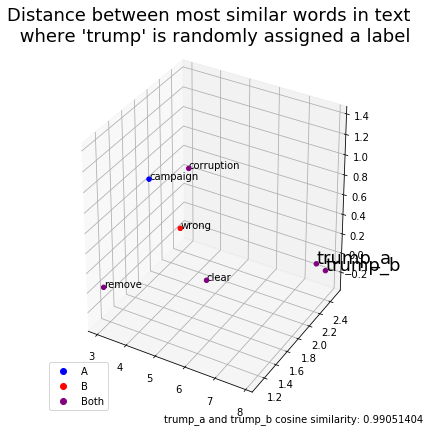

CPU times: user 1min 20s, sys: 3.2 s, total: 1min 24s
Wall time: 27.6 s


In [709]:
%%time
# generate random labels
rand_labels = [random.choice('ab') for label in labels]

# tag keywords with random labels and append to a list
rtrump_tweets = []
for i in range(len(tweets)):
    try:
        rtrump_tweets.append(prep.tag_keywords('trump', tweets[i], rand_labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize randomly tagged tweets
rtrump_tweets = prep.multi_lemmatizer(rtrump_tweets, threads = 6)

# drop single letters
for i in range(len(rtrump_tweets)):
    rtrump_tweets[i] = [word for word in rtrump_tweets[i] if len(word) > 1]
    
# train and save word2vec
rtrump_model = Word2Vec(rtrump_tweets, window = 10)
#rtrump_model.save('rtrump.model')
# Get top 5 words for each label
atrump_words = similar_words('trump_a', rtrump_model, topn = 5)
btrump_words = similar_words('trump_b', rtrump_model, topn = 5)
# get cosin similarity for key word
rtrump_sim = rtrump_model.wv.similarity('trump_a', 'trump_b')
# generate dictionary of most similar words and their appropriate labels
rtrump_dict = similar_dict(atrump_words, btrump_words, ['A', 'B'])

# fit pca model
data = rtrump_model[rtrump_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, rtrump_model, rtrump_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['trump_a', 'trump_b']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['A', 'B', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'trump\' is randomly assigned a label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'trump_a and trump_b cosine similarity: ' + str(rtrump_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('trump_rand.png')
plt.show()

### Top n words summary for 'trump'

In [723]:
trumpr_df = pd.DataFrame(ptrump_model.wv.most_similar('trump_r', topn = 10), columns = ['word2', 'cosine sim'])
trumpr_df['word1'] = 'trump_r'

trumpd_df = pd.DataFrame(ptrump_model.wv.most_similar('trump_d', topn = 10), columns = ['word2', 'cosine sim'])
trumpd_df['word1'] = 'trump_d'

trumpa_df = pd.DataFrame(rtrump_model.wv.most_similar('trump_a', topn = 10), columns = ['word2', 'cosine sim'])
trumpa_df['word1'] = 'trump_a'

trumpb_df = pd.DataFrame(rtrump_model.wv.most_similar('trump_b', topn = 10), columns = ['word2', 'cosine sim'])
trumpb_df['word1'] = 'trump_b'

trump_df = pd.concat([trumpr_df, trumpd_df, trumpa_df, trumpb_df]).reset_index(drop=True)
trump_df.to_csv('trump top n.csv', index=False)

# Impeach

### Impeach party labels

In [ ]:
%%time
# tag keywords
pimpeach_tweets = []
for i in range(len(tweets)):
    try:
        pimpeach_tweets.append(prep.tag_keywords('impeach', tweets[i], labels[i]))
    except:
        print('failed at '+ str(i))

# lemmatize
pimpeach_tweets = prep.multi_lemmatizer(pimpeach_tweets, threads = 6)

# drop single letters
for i in range(len(pimpeach_tweets)):
    pimpeach_tweets[i] = [word for word in pimpeach_tweets[i] if len(word) > 1]

# train word2vec
pimpeach_model = Word2Vec(pimpeach_tweets, window = 10)
pimpeach_model.save('pimpeach.model')
# assign data to variables
rimpeach_words = similar_words('impeach_r', pimpeach_model, topn = 5)
dimpeach_words = similar_words('impeach_d', pimpeach_model, topn = 5)
pimpeach_sim = pimpeach_similarity = pimpeach_model.wv.similarity('impeach_r', 'impeach_d')
pimpeach_dict = similar_dict(rimpeach_words, dimpeach_words, ['Republican', 'Democrat'])

# fit pca model
data = pimpeach_model[pimpeach_model.wv.vocab]
pca = PCA(n_components=3)
result = pca.fit_transform(data)

# convert pca model to df
pcdf = pca2df(result, pimpeach_model, pimpeach_dict)

# 3d plot with labels
fig = plt.figure(figsize = [6, 6])
ax = fig.add_subplot(111, projection='3d')

# define parameters
x = pcdf.pc1
y = pcdf.pc2
z = pcdf.pc3

# plot the points
scatter = ax.scatter(x, y, z, label=pcdf.label, color=pcdf.color, depthshade=False)

# label the points
for i in range(len(pcdf['word'])):
    label = pcdf.word[i]
    if label in ['impeach_r', 'impeach_d']:
        ax.text(x[i], y[i], z[i], s=label, size=18, zorder=1, color='k', horizontalalignment = 'left')
    else:
        ax.text(x[i], y[i], z[i], s=label, size=10, zorder=1, color='k', horizontalalignment = 'left')

# create legend
scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='purple', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], ['A', 'B', 'Both'], numpoints = 1, loc = 3)

# title and subtext
plt.title('Distance between most similar words in text \n where \'impeach\' is assigned a party label', y=1.05, fontsize = 18)
plt.figtext(0.99, 0.01, 'impeach_r and impeach_d cosine similarity: ' + str(pimpeach_sim), horizontalalignment='right')
plt.tight_layout()
plt.savefig('impeach_party.png')
plt.show()